In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features,
                      get_array_from_features,
                      filter_binary_array_by_min_size)

from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from skimage.restoration import denoise_tv_bregman

The goal of this notebook is to demonstrate how to use similar techniques discussed in the previous notebook to detect forest loss, which we identify according to loss in HV backscatter as done [here](https://www.sciencedirect.com/science/article/pii/S0034425714001527).

# Inspecting the data

In [2]:
data_dir = Path('data')
tifs = sorted(list(data_dir.glob('*HV*.tif')))
tifs

[PosixPath('data/AP_07915_FBD_F0150_RT2_HV_20070720.tif'),
 PosixPath('data/AP_12612_FBD_F0150_RT2_HV_20080606.tif')]

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, tifs))

with rasterio.open(tifs[0]) as ds:
    profile = ds.profile

In [4]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 600, 'height': 600, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 440228.8125,
       0.0, -30.0, 937448.125), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

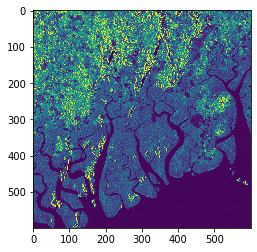

In [5]:
plt.imshow(bands[0])

# Despeckle

In [6]:
def fwd(img):
    return 10 * np.log10(img)

def bwd(img):
    return 10**(img / 10)

def tv_denoise(img, weight):
    img_db = fwd(img)
    img_db_tv = denoise_tv_bregman(img_db, weight)
    img_tv = bwd(img_db_tv)
    return img_tv

def tv_partial(band):
    return tv_denoise(band, .5)

In [7]:
bands_tv = list(map(tv_partial, bands))

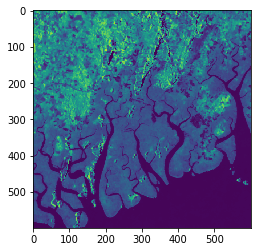

In [8]:
plt.imshow(bands_tv[0])

In [9]:
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
diff = hv_1 - hv_0

In [10]:
p_hv = profile.copy()
p_hv['count'] = 1
with rasterio.open('hv_0.tif', 'w', **p_hv) as ds:
    ds.write(hv_0, 1)
with rasterio.open('hv_1.tif', 'w', **p_hv) as ds:
    ds.write(hv_1, 1)

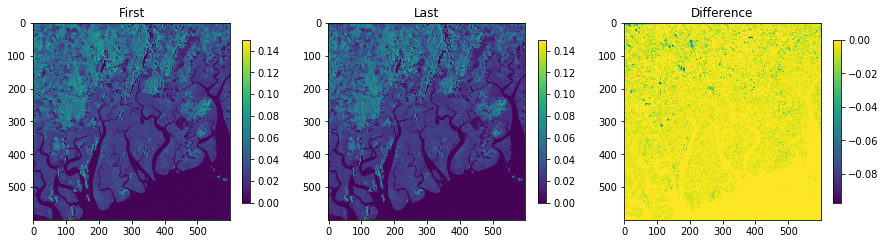

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(hv_0, vmax=.15)
ax[0].set_title('First')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(hv_1, vmax=.15)
ax[1].set_title('Last')
fig.colorbar(im, ax=ax[1], shrink=.3)

ax[2].set_title('Difference')
im = ax[2].imshow(diff, vmax=0)
fig.colorbar(im, ax=ax[2], shrink=.3)

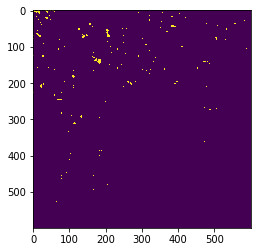

In [12]:
change_class = (diff < -.025).astype(int)
plt.imshow(change_class)

We can experiment with a range of thresholds between `-0.05` and `-0.01`.

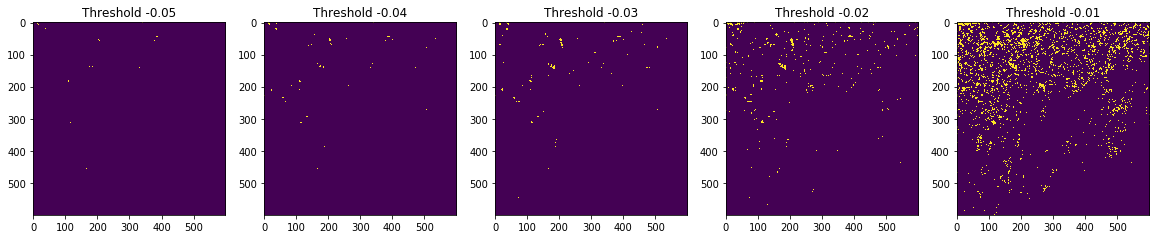

In [13]:
thresholds = np.linspace(-.05, -.01,5)
N = len(thresholds)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, t) in zip(ax.ravel(), thresholds):
    ax.imshow((diff < t).astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

# Exercise 1

Experiment with thresholds to determine areas where HV increases.

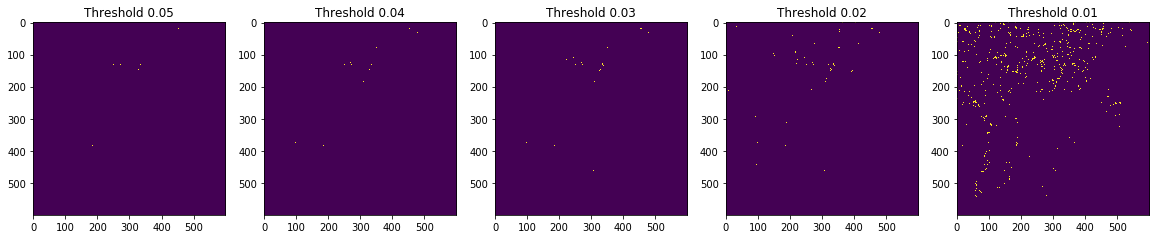

In [14]:
## Answer
thresholds = np.linspace(.05, .01,5)
N = len(thresholds)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, t) in zip(ax.ravel(), thresholds):
    ax.imshow((diff > t).astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

## Morphological Filtering

We can actually segment a binary array into contiguous parts using [`label`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html#scipy.ndimage.measurements.label). Using these labels and measuring their size, we can actually filter according to size.

Below, we filter those areas that are less than 25 pixels.

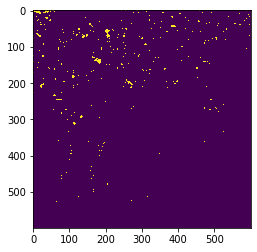

In [15]:
change_class = (diff < -.02).astype(int)
plt.imshow(change_class)

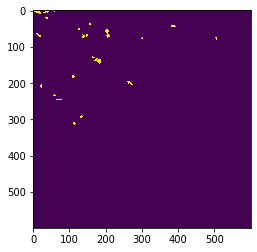

In [16]:
change_class_filtered = filter_binary_array_by_min_size(change_class, 25)

plt.imshow(change_class_filtered)

In [17]:
polygonize_array_to_shapefile(change_class_filtered, 
                              profile, 
                              'changes_hv_decrease', 
                              mask=~(change_class_filtered.astype(bool)))

# Using Superpixels

Let's segment according to the first and last image according to our [paper](https://www.mdpi.com/2072-4292/11/5/556) and aggregate the differences.

In [18]:
superpixel_labels = felzenszwalb(np.stack([hv_0, hv_1], axis=2), 
                                 scale=.5, 
                                 sigma=0, 
                                 min_size=15, 
                                 multichannel=True)

# Exercise 2

Use k-means to determine the change threshold using the superpixels found above and save to a shapefile. I used three classes.

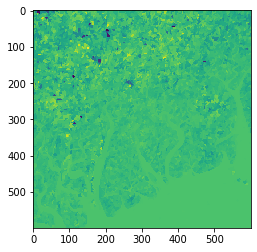

In [19]:
## Answer

mean_features = get_superpixel_means_as_features(superpixel_labels, diff)
mean_array = get_array_from_features(superpixel_labels, mean_features)
plt.imshow(mean_array)

In [20]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0,
           )
X_train = mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

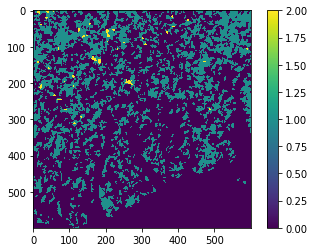

In [21]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)
plt.colorbar()

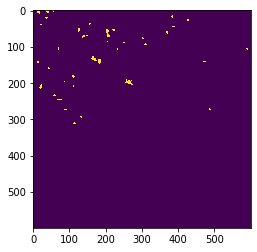

In [22]:
## Answer

plt.imshow(classes == 2)


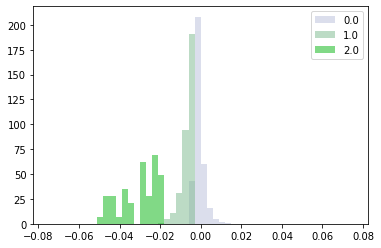

In [23]:
## Answer

for class_num in np.unique(classes):
    plt.hist(mean_features[class_features == class_num], 
             range=(-.075, .075), 
             bins=50, 
             alpha=.5, 
             label=str(class_num),
             density=True,
             color=[np.random.random(3)])
plt.legend()

In [24]:
## Answer

changes = (classes == 2).astype(int)
polygonize_array_to_shapefile(changes, 
                              profile, 
                              'superpixel_hv_loss', 
                              mask=~(changes.astype(bool)))

One could easily identify the class with greates hv loss to remove the dependence of the above approach on the user.

# Acknowledgements

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.
